## 정확히 이해되지 않은 개념

+ Embedding

# 영화 리뷰를 통한 텍스트 분류

본 튜토리얼은 [텐서플로우 공식 튜토리얼](https://www.tensorflow.org/tutorials/keras/text_classification)을 참고하여 제가 이해한 내용을 바탕으로 작성되었습니다.

이번 튜토리얼에서는 영화 리뷰(review) 텍스트를 긍정(positive) 또는 부정(negative)으로 분류해봅니다. 이번 예제는 **이진(binary) 또는 클래스(class)가 두 개인 분류 문제**입니다. **이진 분류는 머신러닝에서 중요하고 널리 사용됩니다.**

[인터넷 영화 데이터베이스](https://www.imdb.com/)(Internet Movie Database)에서 수집한 50,000개의 영화 리뷰 텍스트를 담은 **IMDB 데이터셋**을 사용합니다. **25,000개의 리뷰는 훈련용**으로, **나머지 25,000개는 테스트용**으로 나뉘어져 있습니다. 훈련 세트와 테스트 세트의 클래스는 균형이 잡혀 있습니다. 즉, 긍정적인 리뷰와 부정적인 리뷰의 개수가 동일합니다.

keras와 numpy를 임포트합니다.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

## 1. IMDB 데이터셋 다운로드

IMDB 데이터셋은 텐서플로와 함께 제공됩니다. **리뷰(단어의 시퀀스(sequence))**는 미리 전처리해서 **정수 시퀀스로 변환**되어 있습니다. **각 정수는 어휘 사전에 있는 특정 단어를 의미**합니다.

다음 코드로 IMDB 데이터셋을 컴퓨터에 다운로드해봅시다.(이전에 다운로드를 받았다면 캐시된 복사본을 사용합니다)

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 1s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

매개변수 `num_words=10000`은 훈련 데이터에서 가장 많이 등장하는 상위 10,000개의 단어를 선택합니다. **데이터 크기를 적당하게 유지하기 위해** 드물게 등장하는 단어는 제외합니다.

## 2. 데이터 탐색

데이터 형태를 알아보겠습니다. IMDB 데이터셋의 샘플은 전치리된 정수 배열입니다.  이 정수는 영화 리뷰에 나오는 단어를 나타냅니다. 레이블(label)은 정수 0 또는 1입니다.
+ 0 : 부정적인 리뷰
+ 1 : 긍정적인 리뷰

In [3]:
print("훈련 샘플: {}, 레이블: {}".format(len(train_data), len(train_labels)))

훈련 샘플: 25000, 레이블: 25000


리뷰 텍스트는 어휘 사전의 특정 단어를 나타내는 정수로 변환되어 있습니다. 

첫 번째 리뷰를 확인해봅시다.

In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


영화 리뷰들은 길이가 다릅니다. 신경망의 입력은 길이가 같아야 하기 때문에 이 문제는 나중에 해결하겠습니다.

다음 코드는 첫 번째 리뷰와 두 번째 리뷰에서 단어의 개수를 출력합니다.

In [5]:
len(train_data[0]), len(train_data[1])

(218, 189)

### 정수를 단어로 다시 변환하기

정수를 다시 텍스트로 변환해봅시다.

In [6]:
# 단어와 정수 인덱스를 매핑한 딕셔너리를 다운로드한다.
# {단어: 정수} 형태의 딕셔너리이다.
word_index = imdb.get_word_index()

# 기존에 매핑된 정수 값에 +3을 한다. 이 과정을 거치면 word_index[0, 1, 2, 3]이 비어있게 된다.
word_index = {k:(v+3) for k, v in word_index.items()}
# word_index[0, 1, 2, 3]을 채워준다.
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

# key값과 value값의 위치를 바꿔놓은 reverse 딕셔너리를 하나 만들어준다.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# 정수 배열(reverse_word_index의 key)이 들어왔을 때 이에 대응되는 단어(reverse_word_index의 value)를 공백으로 결합해서 출력.
# 대응되는 단어가 없는 정수가 들어왔을 때는 '?' 출력
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


이제 `decode_review`함수를 사용해 첫 번째 리뷰 텍스트를 출력할 수 있습니다.

In [7]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

(PAD는 아래의 패딩 과정을 수행하면서 부족한 길이만큼 0으로 매꿔주었기 때문에 발생했다)

## 3. 데이터 준비

리뷰(정수 배열)는 신경망에 주입하기 전에 텐서로 변환되어야 합니다. 변환하는 방법에는 몇 가지가 있습니다.

+ 원-핫 인코딩(one-hot encoding) : 정수 배열을 0과 1로 이루어진 벡터로 변환합니다. 예를 들어 배열[3, 5]을 인덱스 3과 5만 1이고 나머지는 모두 0인 10,000차원 벡터로 변환할 수 있습니다. 이후 실수 벡터 데이터를 다룰 수 있는 layer(dense)를 신경망의 첫 번째 layer로 사용합니다. 이 방법은 `num_words * num_reviews` 크기의 행렬이 필요하기 때문에 **메모리를 많이 사용**합니다.
+ 패딩(padding) : **정수 배열의 길이가 모두 같도록 패딩(padding)을 추가**해 `max_length * num_reviews` 크기의 정수 텐서를 만듭니다. 이런 형태의 텐서를 다룰 수 있는 임베딩(embedding) layer를 신경망의 첫 번째 layer로 사용할 수 있습니다.

이번 튜토리얼에서는 **두 번째 방식**을 사용합니다.

영화 리뷰의 길이가 같아야 하므로 [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) 함수를 사용해 길이를 맞추겠습니다.

+ pad_sequences : 2차원의 정수 배열을 2차원의 넘파이 배열로 변환한다. `maxlen`를 설정하면 각 행이 그보다 짧은 길이인 경우 부족한 길이만큼 앞(padding='pre') 또는 뒤(padding='post')를 특정 값(value=n)으로 채운다. `maxlen`을 초과한 길이일 경우 앞(truncating='pre') 또는 뒤(truncating='post')를 자른다.
+ pad_sequences(sequence, value, padding, maxlen)

(디폴트 값 - value : 0, padding='pre', dtype=int32, truncating='pre', maxlen=가장 긴 행의 길이)

In [8]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data, 
                                                        padding='post', 
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

이전에는 훈련 세트의 첫 번째와 두 번째의 데이터의 길이가 달랐습니다. 위의 처리 과정을 거친 후에 샘플의 길이를 다시 확인해 보겠습니다.

In [9]:
len(train_data[0]), len(train_data[1])

(256, 256)

길이가 같아졌음을 확인할 수 있습니다.

첫 번째 리뷰 내용을 확인해 보겠습니다.

In [10]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 4. 모델 구성

신경망에 layer를 쌓을 때 두 가지를 결정해야 합니다.

+ 모델에서 얼마나 많은 층을 사용할 것인가?
+ 각 층에서 얼마나 많은 hidden unit을 사용할 것인가?

이 예제의 입력 데이터는 단어 인덱스의 배열입니다. 예측할 레이블은 0 또는 1입니다. 이 문제에 맞는 모델을 구성해 보겠습니다.

In [11]:
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


층을 순서대로 쌓아 분류기(classifier)를 만듭니다.



1.   첫 번째 층은 `Embedding` 층입니다. 이 층은 정수로 인코딩된 단어를 입력 받고 각 단어 인덱스에 해당하는 임베딩 벡터를 찾습니다. 이 벡터는 모델이 훈련되면서 학습됩니다. 이 벡터는 출력 배열에 새로운 차원으로 추가됩니다. 최종 차원은 (batch, sequence, embedding)이 됩니다.
+ [언어의 벡터화(Word Embedding)](https://simpling.tistory.com/1)
+ vocab_size : data의 총단어 개수
+ 16 : 차원이 16인 벡터를 만든다는 뜻. 즉, 행의 길이가 16인 벡터를 만든다.
+ 특정 단어에 대해 랜덤하게 16개의 실수형 가중치를 생성한다.
+ 하나의 리뷰에 차원이 16인 벡터가 256개 생성된다.(2차원 배열)
2.   두 번째 층은 `GlobalAveragePooling1D` 층입니다. 이 층은 `sequence` 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환합니다. 길이가 다른 입력을 다루는 가장 간단한 방법입니다.
+ 앞서 임베딩 레이어에서 각 열의 평균을 구한 크기 16의 벡터를 리턴한다.
+ 2차원의 데이터를 1차원으로 리턴하는 효과.
3.   세 번째 층은 16개의 hidden unit을 가진 완전 연결(fully-connected)층입니다.
4.   마지막 층은 하나의 출력 노드를 가진 완전 연결 층입니다. `sigmoid` 활성화 함수를 사용하여 0~1 사이의 실수를 출력합니다. 이 값은 확률 또는 신뢰도를 나타냅니다. 

0에 가까우면 0, 1에 가까우면 1의 클래스로 분류됩니다. 이를 테스트 레이블과 비교해서 정확도를 측정합니다.

즉, 하나의 리뷰 속 단어들을 랜덤으로 가중치를 둬서 하나의 확률로 리턴한 다음 이 리뷰가 원래 부정적(0)이었나 긍정적(1)이었나를 test_labels를 보고 버릴 것인지 취할 것인지 판단 후 최적화하면서 학습합니다.



### Hidden Unit

위 모델에는 입력(첫 번째 층)과 출력(마지막 층) 사이에 두 개의 숨겨진 층이 있습니다.

모델에 많은 Hidden Unit(고차원의 표현 공간)과 층이 있다면 신경망은 더 복잡한 표현을 학습할 수 있습니다. 하지만 신경망의 계산 비용이 많이 들고 원치않는 패턴을 학습할 수도 있습니다. 이런 표현은 **훈련 데이터의 성능을 향상시키지만 테스트 데이터에서는 어느 정도선까지만 성능이 향상됩니다.** 이를 **과대적합(overfitting)**이라고 부릅니다. 후에 이에 대해 알아보겠습니다.

### 모델 컴파일

모델이 훈련하려면 손실 함수(loss function)과 옵티마이저(optimizer)가 필요합니다. 이번 예제는 **이진 분류 문제이고 모델이 확률을 출력하므로(출력층의 유닛이 하나이고 sigmoid 활성화 함수를 사용하므로)**, `binary_crossentropy` 손실 함수를 사용하겠습니다.

다른 손실 함수를 선택할 수 없는 것은 아닙니다. 예를 들어 `mean_squared_error`를 선택할 수 있습니다. 하지만 일반적으로 `binary_crossentropy`가 확률을 다루는데 적합합니다. 이 함수는 확률 분포 간의 거리를 측정합니다. 여기에서는 정답인 타깃 분포와 예측 분포 사이의 거리입니다.

나중에 회귀(regression)문제에 대해 살펴 볼 때 평균 제곱 오차(mean_squared error) 손실 함수를 어떻게 사용하는지 알아 보겠습니다.

옵티마이저로는 Adam 알고리즘을 구현한 AdamOptimizer를 사용합니다. 경사하강법을 사용하는 GradientDescentOptimizer보다 성능이 좋다고 합니다.

이제 모델이 사용할 옵티마이저와 손실 함수를 설정해보겠습니다.

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## 5. 검증 세트 만들기

모델을 훈련할 때 모델이 만난 적 없는 데이터에서 정확도를 확인하는 것이 좋습니다. 원본 훈련 데이터에서 10,000개의 샘플을 떼어내어 검증 세트를 만들겠습니다.

In [13]:
x_val = train_data[:10000]  # 0~9999, 검증 데이터(10,000개)
partial_x_train = train_data[10000:] # 10000~24999, 훈련 데이터(15,000개)

y_val = train_labels[:10000]  # 0~9999, 검증 데이터
partial_y_train = train_labels[10000:]  # 10000~24999, 훈련 데이터

## 6. 모델 훈련

훈련 데이터셋(partial_x_train, partial_y_train)을 512개의 작은 미니배치(mini-batches)로 분할해 입력으로 사용합니다.

512개씩 나누어 전체 훈련 데이터셋을 모델 학습에 사용하는 것을 40번 반복합니다.

모델이 학습되는 동안 모델의 손실과 정확도를 계산하기 위해 검증 데이터셋(x_val, y_val)을 사용합니다.

In [14]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 4s 18ms/step - loss: 0.6922 - accuracy: 0.5628 - val_loss: 0.6907 - val_accuracy: 0.6677
Epoch 2/40
30/30 [==============================] - 0s 13ms/step - loss: 0.6875 - accuracy: 0.6745 - val_loss: 0.6838 - val_accuracy: 0.7051
Epoch 3/40
30/30 [==============================] - 0s 12ms/step - loss: 0.6777 - accuracy: 0.7500 - val_loss: 0.6719 - val_accuracy: 0.6901
Epoch 4/40
30/30 [==============================] - 0s 12ms/step - loss: 0.6609 - accuracy: 0.7431 - val_loss: 0.6525 - val_accuracy: 0.7567
Epoch 5/40
30/30 [==============================] - 0s 12ms/step - loss: 0.6357 - accuracy: 0.7784 - val_loss: 0.6253 - val_accuracy: 0.7774
Epoch 6/40
30/30 [==============================] - 0s 13ms/step - loss: 0.6022 - accuracy: 0.7988 - val_loss: 0.5917 - val_accuracy: 0.7897
Epoch 7/40
30/30 [==============================] - 0s 12ms/step - loss: 0.5632 - accuracy: 0.8188 - val_loss: 0.5546 - val_accuracy: 0.7993
Epoch 8/40
30

## 7. 모델 평가

모델의 성능을 확인해봅시다. 손실과 정확도를 반환합니다.

In [15]:
results = model.evaluate(test_data, test_labels, verbose=2)

print(results)

782/782 - 1s - loss: 0.3232 - accuracy: 0.8735
[0.3232339918613434, 0.873520016670227]


이번 예제는 매우 단순한 방식을 사용하므로 **87%의 정확도**를 달성했습니다. 좀 더 심층적인 방법을 사용하면 모델은 95%에 가까운 정확도를 얻습니다.

## 8. 정확도와 손실 그래프 그리기

`model.fit()`은 `History` 객체를 반환합니다. `History`에는 훈련하는 동안 일어난 모든 정보가 담긴 딕셔너리가 들어있습니다.

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

네 개의 항목이 있습니다. 훈련과 검증 단계에서 모니터링하는 지표들입니다.

훈련 손실과 검증 손실을 그래프로 그려 보고, 훈련 정확도와 검증 정확도 역시 그래프로 그려서 비교해 보겠습니다.

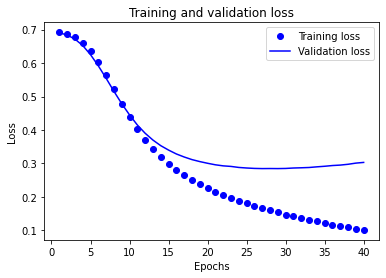

In [17]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 'bo'는 파란색 점입니다.
plt.plot(epochs, loss, 'bo', label='Training loss')
# 'b'는 파란 실선입니다.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()  # 범례를 나타낸다.

plt.show()

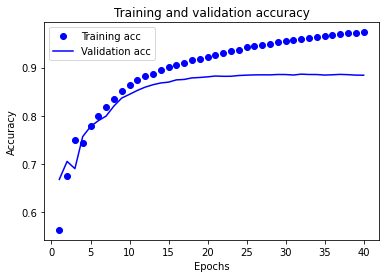

In [18]:
plt.clf()  # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()  # 범례를 나타낸다.

plt.show()

훈련 손실은 에포크마다 감소하고, 훈련 정확도는 증가합니다. 경사 하강법 최적화를 사용할 때 볼 수 있는 현상입니다. 매 반복마다 최적화 대상의 값을 최소화합니다.

하지만 검증 손실과 검증 정확도에서는 약 20번째 에포크 이후에는 변화가 없습니다. 이렇듯 훈련 데이터셋을 입력으로 사용했을 때보다 검증 데이터셋을 입력으로 사용했을 때 결과가 좋지 못한 것을 오버피팅(overfitting)이라고 합니다.

훈련용 데이터셋에 최적화되어 있어서 새로운 데이터셋을 입력으로 사용시 모델의 성능이 떨어지는 것입니다.

## 9. 예측하기

학습된 모델에 테스트 데이터셋을 입력으로 사용하여 예측해봅시다.

예측된 값 중 10개만 출력해보았습니다. 첫 번째 줄은 신경망의 출력이고, 두 번째 줄은 어느 클래스에 속하는지 판정한 결과입니다.

In [19]:
predictions = model.predict(test_data)
print(predictions[0:10].T)

predict_class=model.predict_classes(test_data)
print(predict_class[0:10].T)

[[0.07413818 0.99991167 0.8404214  0.7174338  0.99543285 0.93125075
  0.97053033 0.01920953 0.9759099  0.9998504 ]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[0 1 1 1 1 1 1 0 1 1]]
